In [1]:
import os

from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")

import jax.numpy as jnp
from jax import random, vmap

from jax.experimental import mesh_utils, multihost_utils
from jax.sharding import Mesh, PartitionSpec as P

from function_diffusion.models import Encoder, Decoder, DiT

from function_diffusion.utils.model_utils import (
    create_autoencoder_state,
    create_diffusion_state,
    create_optimizer,
    compute_total_params,
)
from function_diffusion.utils.train_utils import  sample_ode
from function_diffusion.utils.data_utils import create_dataloader
from function_diffusion.utils.checkpoint_utils import (
    create_checkpoint_manager,
    restore_checkpoint,
)

from model_utils import create_encoder_step, create_decoder_step
from data_utils import create_dataset

/scratch/sifanw/fundiff/kf_reconstruction/div_free


In [2]:
from configs import diffusion

config = diffusion.get_config('fae,dit')

In [3]:
def restore_fae_state(config, encoder, decoder):
    # Create learning rate schedule and optimizer
    lr, tx = create_optimizer(config)

    # Create train state
    state = create_autoencoder_state(config, encoder, decoder, tx)

    # Create checkpoint manager
    fae_job_name = f"{config.autoencoder.model_name}_div_free"

    ckpt_path = os.path.join(os.getcwd(), fae_job_name, "ckpt")
    ckpt_mngr = create_checkpoint_manager(config.saving, ckpt_path)

    # Restore the model from the checkpoint
    fae_state = restore_checkpoint(ckpt_mngr, state)
    print(f"Restored model {fae_job_name} from step", fae_state.step)

    return fae_state


In [4]:
# Initialize function autoencoder
encoder = Encoder(**config.autoencoder.encoder)
decoder = Decoder(**config.autoencoder.decoder)

fae_state = restore_fae_state(config, encoder, decoder)

Restored model FAE_div_free from step 3600


In [5]:
# Initialize diffusion model
dit = DiT(**config.diffusion)
# Create learning rate schedule and optimizer
lr, tx = create_optimizer(config)

# Create diffusion train state
state = create_diffusion_state(config, dit, tx, use_conditioning=True)
num_params = compute_total_params(state)
print(f"Model storage cost: {num_params * 4 / 1024 / 1024:.2f} MB of parameters")

Total number of parameters: 30.47 million
Model storage cost: 116.22 MB of parameters


In [6]:
# Create checkpoint manager
job_name = f"{config.diffusion.model_name}_div_free"
ckpt_path = os.path.join(os.getcwd(), job_name, "ckpt")
# Create checkpoint manager
ckpt_mngr = create_checkpoint_manager(config.saving, ckpt_path)

# Restore the model from the checkpoint
state = restore_checkpoint(ckpt_mngr, state)
print(f"Restored model {job_name} from step", state.step)

Restored model DiT_div_free from step 1890


In [7]:
# Device count
num_local_devices = jax.local_device_count()
num_devices = jax.device_count()
print(f"Number of devices: {num_devices}")
print(f"Number of local devices: {num_local_devices}")

# Create sharding for data parallelism
mesh = Mesh(mesh_utils.create_device_mesh((jax.device_count(),)), "batch")
state = multihost_utils.host_local_array_to_global_array(state, mesh, P())
fae_state = multihost_utils.host_local_array_to_global_array(fae_state, mesh, P())

Number of devices: 1
Number of local devices: 1


In [8]:
# Create encoder and decoder steps
encoder_step = create_encoder_step(encoder, mesh)
decoder_step = create_decoder_step(decoder, mesh)

In [ ]:
# Get test dataset
_, test_dataset = create_dataset(config)
test_loader = create_dataloader(test_dataset,
                                batch_size=2,
                                num_workers=config.dataset.num_workers,
                                shuffle=False)

/scratch/sifanw/anaconda3/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [10]:
# Create uniform grid for evaluation
h, w = 256, 256

x_coords = jnp.linspace(0, 1, h)
y_coords = jnp.linspace(0, 1, w)
x_coords, y_coords = jnp.meshgrid(x_coords, y_coords, indexing='ij')
coords = jnp.hstack([x_coords.reshape(-1, 1), y_coords.reshape(-1, 1)])
coords = multihost_utils.host_local_array_to_global_array(coords, mesh, P())

In [11]:
rng_key = jax.random.PRNGKey(888)

d = 4   # downsampling factor  # [1, 2, 4]
noise_level = 0.2

u_pred_list = []
v_pred_list = []
u_true_list = []
v_true_list = []
div_pred_list = []
uv_downsampled_list = []

iters = 0 
for batch in tqdm(test_loader):
    iters += 1

    rng_key, *keys = random.split(rng_key, 3)
    
    batch = jax.tree.map(jnp.array, batch)

    uv = batch
    uv_downsammpled = batch[:, ::d, ::d]

    noise = random.normal(keys[0], uv_downsammpled.shape) * 0.2 * noise_level
    uv_downsammpled = uv_downsammpled + noise

    uv_batch = (jnp.ones_like(uv), uv, jnp.ones_like(uv))
    c_batch = (jnp.ones_like(uv_downsammpled), uv_downsammpled, jnp.ones_like(uv_downsammpled))

    print(uv_batch[0].shape, uv_batch[1].shape, uv_batch[2].shape)
    print(c_batch[0].shape, c_batch[1].shape, c_batch[2].shape)

    # # Shard the batch across devices
    uv_batch = multihost_utils.host_local_array_to_global_array(
        uv_batch, mesh, P("batch")
        )
    c_batch = multihost_utils.host_local_array_to_global_array(
        c_batch, mesh, P("batch")
        )

    z_uv = encoder_step(fae_state.params[0], uv_batch)
    z_c = encoder_step(fae_state.params[0], c_batch)

    print(z_uv.shape, z_c.shape)

    z0 = random.normal(keys[1], shape=z_uv.shape)

    z1_new, _ = sample_ode(state, z0=z0, c=z_c, num_steps=100, use_conditioning=True)  
    u_pred, v_pred, _, div_pred = decoder_step(fae_state.params[1], z1_new, coords)

    u_pred = u_pred.reshape(-1, h, w)
    v_pred = v_pred.reshape(-1, h, w)

    u_true = uv[..., 0]
    v_true = uv[..., 1]
    div_pred = div_pred.reshape(-1, h, w)  

    uv_downsammpled = uv_downsammpled.reshape(-1, h//d, w//d, 2)

    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    u_true_list.append(u_true)
    v_true_list.append(v_true)

    div_pred_list.append(div_pred)
    uv_downsampled_list.append(uv_downsammpled)

    if iters ==4:
        break

u_pred = jnp.vstack(u_pred_list)
u_true = jnp.vstack(u_true_list)
div_pred = jnp.vstack(div_pred_list)
uv_downsammpled = jnp.vstack(uv_downsampled_list)

  0%|          | 0/640 [00:00<?, ?it/s]/scratch/sifanw/anaconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(2, 256, 256, 2) (2, 256, 256, 2) (2, 256, 256, 2)
(2, 64, 64, 2) (2, 64, 64, 2) (2, 64, 64, 2)
(2, 512, 256) (2, 512, 256)


  0%|          | 1/640 [00:55<9:49:25, 55.34s/it]

(2, 256, 256, 2) (2, 256, 256, 2) (2, 256, 256, 2)
(2, 64, 64, 2) (2, 64, 64, 2) (2, 64, 64, 2)
(2, 512, 256) (2, 512, 256)


  0%|          | 2/640 [01:16<6:16:12, 35.38s/it]

(2, 256, 256, 2) (2, 256, 256, 2) (2, 256, 256, 2)
(2, 64, 64, 2) (2, 64, 64, 2) (2, 64, 64, 2)
(2, 512, 256) (2, 512, 256)


  0%|          | 3/640 [01:39<5:15:20, 29.70s/it]

(2, 256, 256, 2) (2, 256, 256, 2) (2, 256, 256, 2)
(2, 64, 64, 2) (2, 64, 64, 2) (2, 64, 64, 2)
(2, 512, 256) (2, 512, 256)


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]/scratch/sifanw/anaconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

  0%|          | 3/640 [02:03<7:15:45, 41.04s/it]


In [13]:
def compute_error(pred, y):
    return jnp.linalg.norm(pred.flatten() - y.flatten()) / jnp.linalg.norm(y.flatten())

u_error = vmap(compute_error)(u_pred, u_true)
v_error = vmap(compute_error)(v_pred, v_true)


print("Mean u relative error:", jnp.mean(u_error))
print("Mean v relative error:", jnp.mean(v_error))


Mean u relative error: 0.2757785
Mean v relative error: 0.29878867


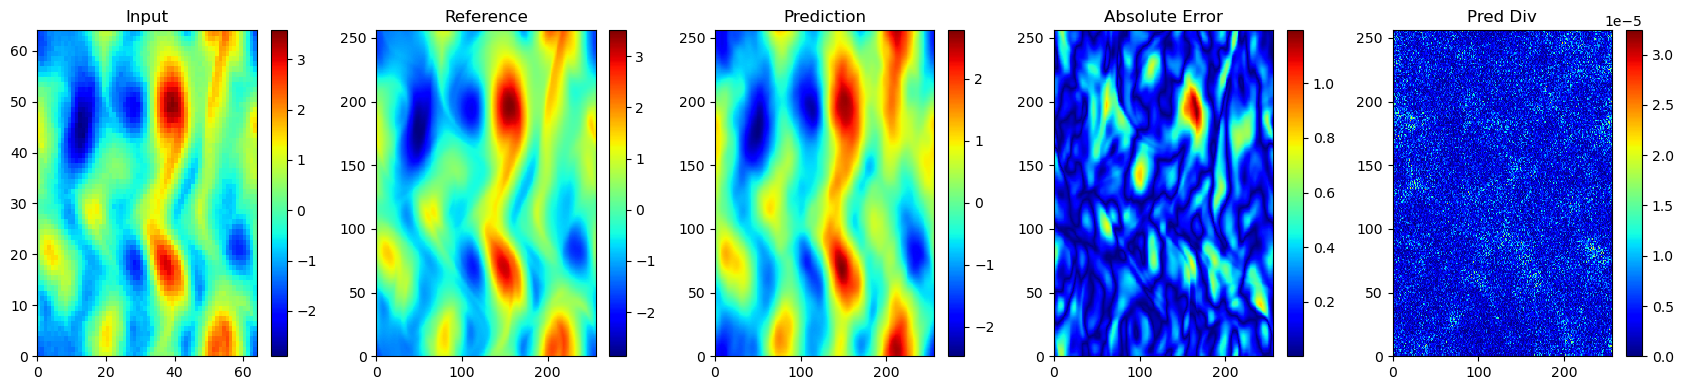

In [14]:
# Visualization of some examples
import matplotlib.pyplot as plt

k = 0

fig = plt.figure(figsize=(17, 4))
plt.subplot(1, 5, 1)
plt.title('Input')
plt.pcolor(uv_downsammpled[k, :, :, 0], cmap='jet')
plt.colorbar()

plt.subplot(1, 5, 2)
plt.title('Reference')
plt.pcolor(u_true[k, :, :], cmap='jet')
plt.colorbar()

plt.subplot(1, 5, 3)
plt.title('Prediction')
plt.pcolor(u_pred[k, :, :], cmap='jet')
plt.colorbar()

plt.subplot(1, 5, 4)
plt.title('Absolute Error')
plt.pcolor(jnp.abs(u_pred[k, :, :] - u_true[k, :, :]), cmap='jet')
plt.colorbar()


plt.subplot(1, 5, 5)
plt.title('Pred Div')
plt.pcolor(jnp.abs(div_pred[k, :, :]), cmap='jet')
plt.colorbar()

plt.tight_layout()
plt.show()